<a href="https://colab.research.google.com/github/m1016m/NN/blob/master/%E4%BD%BF%E7%94%A8%E9%9A%A8%E6%A9%9F%E6%A3%AE%E6%9E%97%E6%A8%A1%E5%9E%8B%E9%A0%90%E6%B8%AC%E5%B8%82%E5%A0%B4%E8%B5%B0%E5%90%91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

我們需要更多決策避免過度擬和，也需要考慮更多的市場因素：
決策樹就單純是一棵樹，可是隨機森林就字面上來看就可以知道是100顆數或200顆樹，讓大家來做決定，決策樹中只有考慮到價格，卻沒有考慮到整體市場的走向，價格的波動或市場的信心度，你也可以說市場的信心度隱含在開盤價收盤價中，我們要將其抽取出來，讓其關聯度更強，才不致讓機器因為隱含的太深沉而找不到規律，

我們的資料會使用，每日的間隔，標普500 SPY這個ETF指數的基金，以日期相關的依據存在
- 市場走向
- 價格波動率
- 市場信心度

2016 年論文 [Khaidem, Luckyson, Snehanshu Saha, and Sudeepa Roy Dey. "Predicting the direction of stock market prices using random forest." arXiv preprint arXiv:1605.00003](https://arxiv.org/abs/1605.00003)

使用 Peter Bakker 提供的 [技術指標](https://www.quantopian.com/posts/technical-analysis-indicators-without-talib-code)，包含：

1. [相對強弱指數 RSI](https://tw.tradingview.com/scripts/relativestrengthindex/)
1. [隨機震盪指標 KD](https://tw.tradingview.com/scripts/stochastic/)
1. [累積/派發線 AD](https://tw.tradingview.com/scripts/accumulationdistribution/)
1. [真實波動幅度均值 ATR](https://tw.tradingview.com/scripts/volatility/)
1. [動量指標 Momentum](https://tw.tradingview.com/scripts/momentum/)
1. [資金流量指標 MFI](https://kknews.cc/zh1.tw/invest/b8n5brn.html)
1. [變動率指標 ROC](https://tw.tradingview.com/scripts/rateofchange/)
1. [能量潮指標 OBV](https://tw.tradingview.com/scripts/onbalancevolume/)
1. [順勢指標 CCI](https://tw.tradingview.com/scripts/commoditychannelindex/)
1. [簡易波動指標 EOM](https://tw.tradingview.com/scripts/easeofmovement/)
1. [三重平滑均線 TRIX](https://tw.tradingview.com/scripts/trix/)
1. [旋渦指標 VI](https://tw.tradingview.com/scripts/vortex/)
1. [指數平滑異同移動平均線 MACD](https://www.cmoney.tw/learn/course/technicals/topic/750)
1. [指數移動平均 EMA](https://ey90223.pixnet.net/blog/post/350258995)

首先，加入模組、設定環境常數

In [2]:
!pip install utils

In [5]:
from google.colab import files
uploaded = files.upload()

Saving pandas_techinal_indicators.py to pandas_techinal_indicators.py


In [6]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import pandas_techinal_indicators as ta
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [7]:
%matplotlib inline

np.random.seed(5)
random.seed(5)

設定常數

In [8]:
# 訓練樣本數比例
SPLIT_RATIO = 0.66

加入資料

In [11]:
from google.colab import files
uploaded = files.upload()

Saving SPY_2018.csv to SPY_2018.csv


In [12]:
spy_prices = pd.read_csv('SPY_2018.csv')
del(spy_prices['Date'])
del(spy_prices['Adj Close'])
spy_prices.head()

,Open,High,Low,Close,Volume
0,267.839996,268.809998,267.399994,268.769989,86655700
1,268.959991,270.640015,268.959991,270.470001,90070400
2,271.200012,272.160004,270.540009,271.609985,80636400
3,272.510010,273.559998,271.950012,273.420013,83524000
4,273.309998,274.100006,272.980011,273.920013,57319200


讓資料以時間為權重關聯在一起，但論文作者沒有說明 alpha 值，這邊先用 0.9

In [14]:
# https://www.cjavapy.com/article/451/ 參數說明
def expPreprocessing(df, alpha=0.9):
    edata = df.ewm(alpha=alpha).mean()    
    return edata

In [15]:
# Smoothed by Date
sspy = expPreprocessing(spy_prices)
sspy.head()

,Open,High,Low,Close,Volume
0,267.839996,268.809998,267.399994,268.769989,8.665570e+07
1,268.858173,270.473650,268.818173,270.315454,8.975997e+07
2,270.967938,271.992888,270.369377,271.481698,8.154054e+07
3,272.355942,273.403428,271.792091,273.226356,8.332583e+07
4,273.214601,274.030354,272.861230,273.850654,5.991963e+07


In [16]:
def featureExtraction(data):
    for x in [14, 26, 44, 66, 95]:
        data = ta.relative_strength_index(data, n=x)#相對強弱指數 RSI
        data = ta.stochastic_oscillator_d(data, n=x)#隨機震盪指標 KD
        data = ta.accumulation_distribution(data, n=x)#累積/派發線 AD
        data = ta.average_true_range(data, n=x)#真實波動幅度均值 ATR
        data = ta.momentum(data, n=x)#動量指標 Momentum
        data = ta.money_flow_index(data, n=x)#資金流量指標 MFI
        data = ta.rate_of_change(data, n=x)#變動率指標 ROC
        data = ta.on_balance_volume(data, n=x)#能量潮指標 OBV
        data = ta.commodity_channel_index(data, n=x)#順勢指標 CCI
        data = ta.ease_of_movement(data, n=x)#簡易波動指標 EOM
        data = ta.trix(data, n=x)#三重平滑均線 TRIX
        data = ta.vortex_indicator(data, n=x)#旋渦指標 VI
    
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()#50均線
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()#21均線
    data['ema14'] = data['Close'] / data['Close'].ewm(14).mean()#14均線
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()#5日均線

    # KD 輔助指標
    data = ta.macd(data, n_fast=12, n_slow=26)
    
    del(data['Open'])
    del(data['High'])
    del(data['Low'])
    del(data['Volume'])
    
    return data
   
def computePredictionInt(df, n):
    pred = (df.shift(-n)['Close'] >= df['Close'])
    pred = pred.iloc[:-n]
    return pred.astype(int)

def prepareData(df, horizon):
    data = featureExtraction(df).dropna().iloc[:-horizon]
    data['pred'] = computePredictionInt(data, n=horizon)
    del(data['Close'])
    return data.dropna()

In [17]:
dataset = prepareData(sspy, 10)
print(f'加入技術指標：{np.array(dataset.columns)}')

加入技術指標：['RSI_14' 'SO%d_14' 'Acc/Dist_ROC_14' 'ATR_14' 'Momentum_14' 'MFI_14'
 'ROC_14' 'OBV_14' 'CCI_14' 'EoM_14' 'Trix_14' 'Vortex_14' 'RSI_26'
 'SO%d_26' 'Acc/Dist_ROC_26' 'ATR_26' 'Momentum_26' 'MFI_26' 'ROC_26'
 'OBV_26' 'CCI_26' 'EoM_26' 'Trix_26' 'Vortex_26' 'RSI_44' 'SO%d_44'
 'Acc/Dist_ROC_44' 'ATR_44' 'Momentum_44' 'MFI_44' 'ROC_44' 'OBV_44'
 'CCI_44' 'EoM_44' 'Trix_44' 'Vortex_44' 'RSI_66' 'SO%d_66'
 'Acc/Dist_ROC_66' 'ATR_66' 'Momentum_66' 'MFI_66' 'ROC_66' 'OBV_66'
 'CCI_66' 'EoM_66' 'Trix_66' 'Vortex_66' 'RSI_95' 'SO%d_95'
 'Acc/Dist_ROC_95' 'ATR_95' 'Momentum_95' 'MFI_95' 'ROC_95' 'OBV_95'
 'CCI_95' 'EoM_95' 'Trix_95' 'Vortex_95' 'ema50' 'ema21' 'ema14' 'ema5'
 'MACD_12_26' 'MACDsign_12_26' 'MACDdiff_12_26' 'pred']


拆分 `訓練資料`、`測試資料`

In [18]:
features = [x for x in dataset.columns if x not in ['pred']]
x = dataset[features]

y = dataset['pred']

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=SPLIT_RATIO, random_state=5)

print('訓練 > 特徵數量', len(x_train))
print('訓練 > 標籤數量', len(y_train))
print('測試 > 特徵數量', len(x_test))
print('測試 > 標籤數量', len(y_test))

訓練 > 特徵數量 152
訓練 > 標籤數量 152
測試 > 特徵數量 79
測試 > 標籤數量 79


## 建立模型

- n_jobs：-1 代表使用全部核心
- n_estimators：生成多少顆決策樹
- random_state：隨機碼

In [20]:
Model = RandomForestClassifier(n_jobs=-1, n_estimators=65, random_state=5)
Model.fit(x_train, y_train.values.ravel())

In [21]:
# n_estimators
# 森林中樹木的數量(base estimator的數量)

# 通常此值越大，模型效果往往越好
# 任何模型都有決策邊界，其值達到一定程度時，精確性往往不在上升或開始波動
# 其值越大，計算量與內存消耗量越大，訓練時間越長
# 渴望在訓練難度和模型效果之間取得平衡
# random_state
# 隨機森林中的random_state，其控制的是森林生成的模式(生成一片固定的森林)，而非讓一個森林之中只有一棵樹
# 固定生成的每棵樹的random_state;但是森林中樹跟樹之間還是不一樣
# 不像決策樹的random_state都是生成同一棵樹
# bootstrap
# bagging是通過樣本抽取後有放回的隨機抽樣技術來型成不同的訓練集
# bootstrap就是用來控制抽樣技術的參數

# 參數默認為True:有放回的隨機採樣技術
# 通常這個參數不會被我們設置為False
# 由於是有放回的抽樣技術，樣本可能在新的自助集中出現多次，其他樣本可能被忽略
# 自助集大約平均會包含 63% 的原始數據
# 表示會有37%的數據集被浪費掉，沒有參與建模，其被稱為袋外數據(out of bag data;oob)
# 亦可以被用來作為集成算法的測試集使用
# 亦指在使用隨機森林時，我們可以不劃分測試集和訓練集，只需要用袋外數據來測試模型
# 當原始樣本數及n_estimators不夠大的時候，也很可能沒有數據落在袋外，便無法使用oob數據來測試模型
# oob_score
# 若希望用袋外數據測試，實例化時將oob_score設為True
# RF_classifier = RandomForestClassifier(n_estimators=25,random_state=2,oob_score=True)
# 為True時無須再劃分訓練集及測試集
# 重要屬性
# estimators_
# 使用estimator.estimators_查看森林中所有樹的狀況
# 其返回每棵樹對象構建的參數，為一列表
# 可以發現每棵樹只有random_state不同
# 可使用列表的方式取出某棵樹，再利用.屬性的方式查看該樹的屬性
# estimator.estimators_[0].random_state
# 查看estimator模型裡第0顆樹的random_state之值
# oobscore
# 要是建模oob_score為True時，可使用其屬性查看使用袋外數據測試的結果


In [26]:
prediction = Model.predict(x_test)
table = pd.DataFrame(y_test[:10])
table['模型決策深度'] = prediction[:10]
print(table)
report = classification_report(y_test, prediction)
confusion = confusion_matrix(y_pred=prediction, y_true=y_test)
print('=== 準確度報告 ===')
print(report)
print('=== 混淆矩陣 ===')
print(confusion)

     pred  模型決策深度
423   1.0     1.0
373   1.0     1.0
439   1.0     1.0
370   1.0     1.0
399   1.0     1.0
289   1.0     1.0
501   1.0     1.0
455   1.0     1.0
334   0.0     1.0
493   1.0     1.0
=== 準確度報告 ===
              precision    recall  f1-score   support

         0.0       0.94      0.71      0.81        24
         1.0       0.89      0.98      0.93        55

    accuracy                           0.90        79
   macro avg       0.91      0.85      0.87        79
weighted avg       0.90      0.90      0.89        79

=== 混淆矩陣 ===
[[17  7]
 [ 1 54]]


## 比對 預測結果

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35430 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38598 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28466 missing from current font.
  font.set_

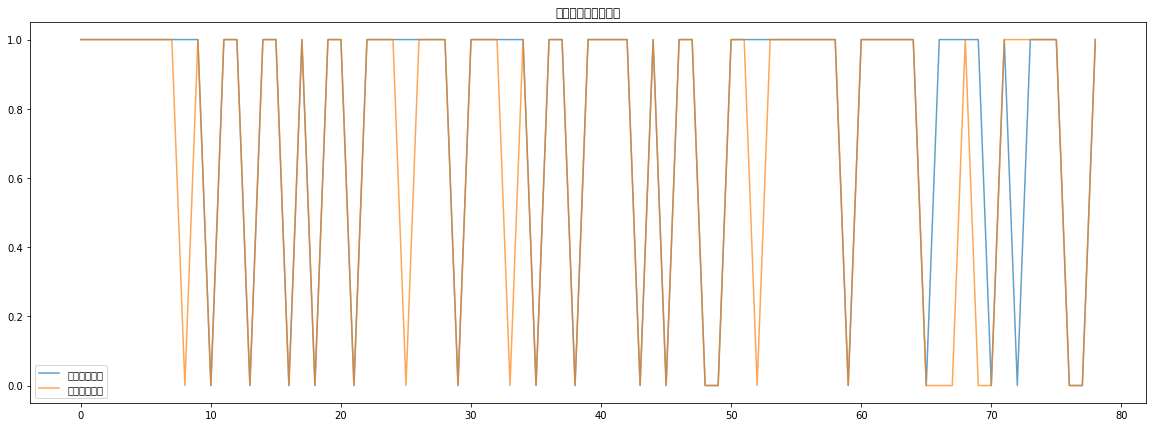

In [23]:
plt.figure(figsize=(20, 7))
plt.plot(np.arange(len(prediction)), prediction, alpha=0.7, label='預測市場漲跌')
plt.plot(np.arange(len(y_test)), y_test, alpha=0.7, label='真實市場漲跌' );
plt.title('測試集中的漲跌預測')
plt.legend();

## 比對 預測機率

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35430 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38598 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28466 missing from current font.
  font.set_

<Figure size 1440x504 with 0 Axes>

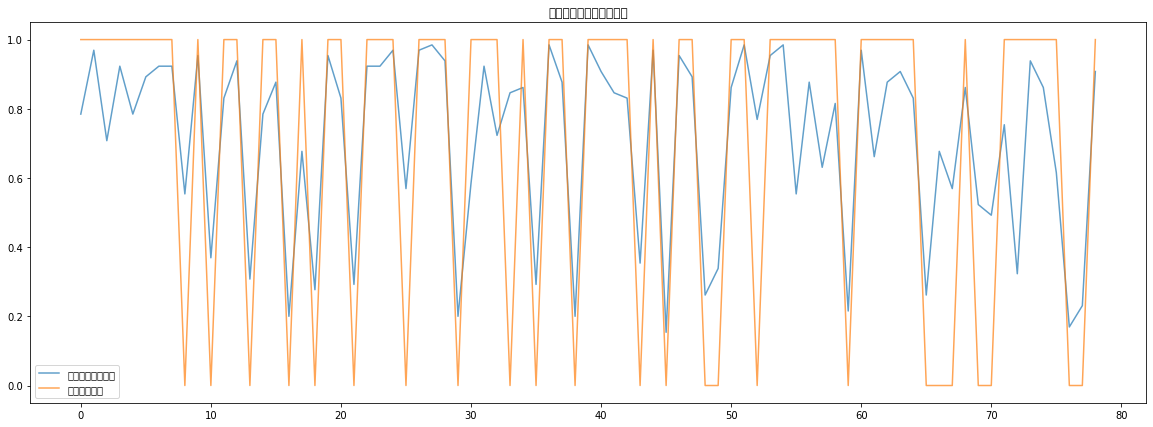

In [24]:
plt.figure(figsize=(20, 7))
probability = Model.predict_proba(x_test)[:, 1]
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(probability)), probability, alpha=0.7, label='預測市場漲跌機率')
plt.plot(np.arange(len(y_test)), y_test, alpha=0.7, label='真實市場漲跌' );
plt.title('測試集中的漲跌機率預測');
plt.legend();

,pred,模型決策深度 5
423,1.0,1.0
373,1.0,1.0
439,1.0,1.0
370,1.0,1.0
399,1.0,1.0
289,1.0,1.0
501,1.0,1.0
455,1.0,1.0
334,0.0,1.0
493,1.0,1.0
